In [1]:
import os
import requests
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import umap

c:\Users\prete\miniconda3\envs\mach-learn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

Using device: cuda

Processing MNIST
Running UMAP on 5000 samples with 784 dimensions


c:\Users\prete\miniconda3\envs\mach-learn\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


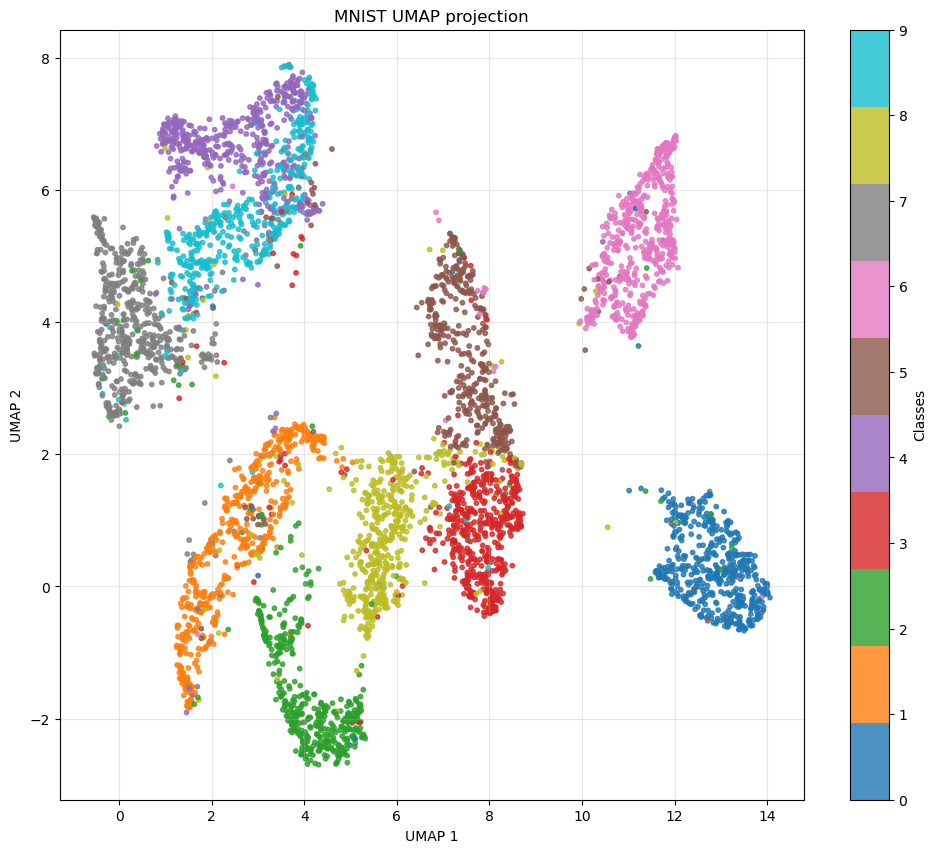


Processing Imagenette
Imagenette found, skipping download.
Classes found: ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
Running UMAP on 5000 samples with 12288 dimensions


c:\Users\prete\miniconda3\envs\mach-learn\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


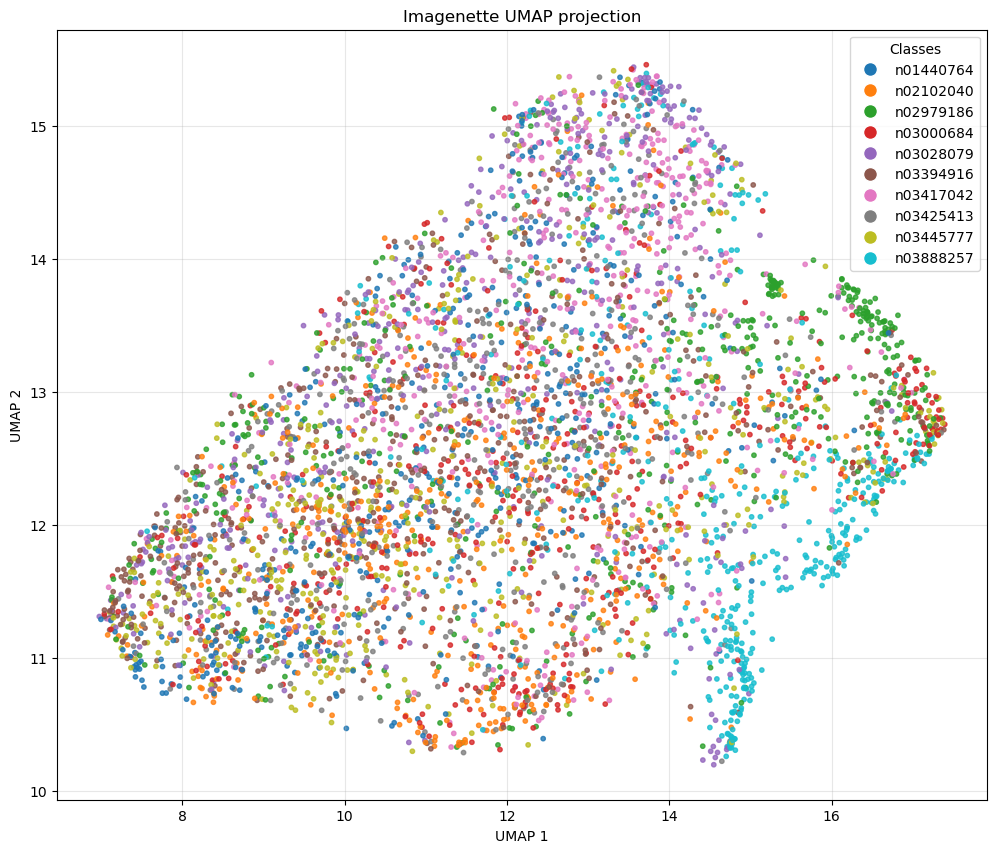

In [ ]:
# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ========================================
# Helper functions for data
# ========================================

def downloadImagenette(root='./data'):
    """
    Downloads Imagenette (160px) and stores it into the specified root directory (creates folder if needed).
    """
    url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz"
    filename = "imagenette2-160.tgz"
    filepath = os.path.join(root, filename)
    extractPath = os.path.join(root, "imagenette2-160")

    if not os.path.exists(root):
        os.makedirs(root)

    # If the extracted folder already exists, do nothing
    if os.path.exists(extractPath):
        print("Imagenette found, skipping download.")
        return extractPath

    print(f"Downloading Imagenette from {url}")
    response = requests.get(url, stream=True)
    with open(filepath, 'wb') as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    
    print("Extracting files")
    with tarfile.open(filepath, 'r:gz') as tar:
        tar.extractall(path=root)
    
    print("Done.")
    return extractPath

def extractFlatData(dataset, numSamples, numClasses=None):
    """
    Extracts a subset of data and flattens images for UMAP.
    Returns data and labels as numpy arrays.
    """
    dataList = []
    labelList = []
    
    # Iterate the dataset, we stop when we collected enough samples.
    indices = np.random.permutation(len(dataset)) # shuffle to get a mix
    count = 0
    for idx in indices:
        img, label = dataset[idx]
        
        # Class filter (optionnal)
        if numClasses is not None and label >= numClasses:
            continue
            
        # Flatten the image: (C, H, W) -> 1D vector
        flatImg = img.view(-1).numpy()
        
        dataList.append(flatImg)
        labelList.append(label)
        
        count += 1
        if count >= numSamples:
            break
            
    return np.array(dataList), np.array(labelList)

def visualizeUMAPProjection(data, labels, title, classesNames=None):
    """
    Computes and displays the UMAP projection.
    """
    print(f"Running UMAP on {data.shape[0]} samples with {data.shape[1]} dimensions")
    
    # UMAP configuration (standard defaults)
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    embedding = reducer.fit_transform(data)
    
    # Plot
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10', s=10, alpha=0.8)
    
    # Create a manual legend
    if classesNames:
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab10(i/10), 
                              label=classesNames[i], markersize=10) for i in range(len(classesNames))]
        plt.legend(handles=handles, title="Classes")
    else:
        plt.colorbar(scatter, label='Classes')
        
    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.grid(True, alpha=0.3)
    plt.show()

# ==========================================
# Main processing
# ==========================================

# Configuration
numSamples = 5000

# MNIST
print("\nProcessing MNIST")
transformMNIST = transforms.Compose([transforms.ToTensor()])
datasetMNIST = torchvision.datasets.MNIST(root='./data', train=True, transform=transformMNIST, download=True)

mnistData, mnistLabels = extractFlatData(datasetMNIST, numSamples)
visualizeUMAPProjection(mnistData, mnistLabels, title="MNIST UMAP projection")

# Imagenette
print("\nProcessing Imagenette")
imagenettePath = downloadImagenette()
trainPath = os.path.join(imagenettePath, 'train') # Imagenette has 'train' and 'val' folders

# Use transforms.Resize because UMAP is slow on large vectors
# We choose 64x64 as a compromise between visibility and speed
transformImagenette = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Load via ImageFolder and retrieve class names for display (this is optional but helpful)
datasetImagenette = ImageFolder(root=trainPath, transform=transformImagenette)
classNames = datasetImagenette.classes 
print(f"Classes found: {classNames}")

imgData, imgLabels = extractFlatData(datasetImagenette, numSamples)
visualizeUMAPProjection(imgData, imgLabels, title="Imagenette UMAP projection", classesNames=classNames)